## How Much Ageism Exists in High Tech?
On August 4, 2017, an article appeared in USA Today titled [Ageism is forcing many to look outside Silicon Valley, but tech hubs offer little respite](https://www.usatoday.com/story/tech/columnist/2017/08/04/ageism-forcing-many-look-outside-silicon-valley-but-tech-hubs-offer-little-respite/479468001/).  It begins:

> For years, job hunting over the age of 40 in the youth-obsessed Silicon Valley could prove hazardous to your career.

> But judging from the experiences of technology workers roaming the country in search of job opportunities elsewhere, ageism is a universal problem in the industry.

The article then describes the experience of one older worker and then continues:

> Age is the silent career killer in the tech industry. While companies openly wrestle with the lack of racial and gender diversity, regularly releasing workforce demographics, they refuse to disclose the average age of their staffers and offer little in the way of internal support for older workers.

Despite this, the article does give some numbers further on in the article:

> The median age of an American worker is 42. Yet at Facebook it's 29, Google 30, Apple 31, Amazon 30 and Microsoft 33, according to self-reported employee data collected by research firm PayScale last year. (It did not collect data this year.) Most job candidates at those companies are 25 to 34 years old, according to data collected by Glassdoor, a jobs and recruiting website.

It's possible to do some investigation of this topic using the Census data that I described in my [prior post](http://usjobdata.blogspot.com/2018/04/pew-research-center-study-on-which_68.html).  Following is my description of that data:

> The following Python code looks at data from the 2016 American Community Survey (ACS). The data can be created by going to the [IPUMS USA website](https://usa.ipums.org/usa/), logging in (creating an account, if necessary), and creating an extract with the variables STATEFIP, COUNTY, MET2013, PUMA, CITIZEN, EMPSTAT, and OCC. The variables YEAR, DATANUM, SERIAL, HHWT, GQ, PERNUM, and PERWT are automatically preselected. For samples, select ACS for 2016. For data format, select .csv. For structure, select rectangular. For more information, see [IPUMS Documentation: User's Guide](https://usa.ipums.org/usa/doc.shtml). You should receive an email when your extract is ready. You can then download, rename it to acs2016.csv, and place it in the same directory as the following Python code and run the code.

The one necessary change to the above is that the variable AGE must also be selected for the extract.  As before, the extract is copied to the file acs2016.csv.  The following code reads this file and lists the percentage of workers with OCC code 1020 (Software developers, applications and systems software) who are in selected age groups.  It will do this for all U.S. counties with 5000 or more such workers and display them in ascending order of the percent who are 65 or older. Following is the code, followed by the output:


[No place for the old? Is software development a young person's game?](https://www.techrepublic.com/article/no-place-for-the-old-is-software-development-a-young-persons-game/)
 

In [15]:
import pandas as pd
# ACS Occupation Codes at https://usa.ipums.org/usa/volii/occ_acs.shtml
# (described at https://www.census.gov/content/dam/Census/library/publications/2016/acs/acs-35.pdf)
#  110 = Computer and information systems managers
# 1010 = Computer programmers
# 1020 = Software developers, applications and systems software 
# print(pd.get_option('display.width'))
pd.set_option('display.width', 120)

def getAgeGroupByCounty(min_count, occs, ages, isort, ascending, title):
    fipref = "https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt"
    mm = pd.read_csv(fipref, skiprows=0, names=['State','StateCode','CountyCode','County','H1'])
    mm['CountyCode'] *= 10

    usa = pd.read_csv("acs2016.csv")
    if len(occs) > 1:
        occ_start = occs[0]
        for i in range(1,len(occs)):
            if occs[i] >= 0:
                occ_end = occs[i]
                usa.loc[usa['OCC'] == occ_end,'OCC'] = occs[0]
            else:
                occ_end = -occs[i]
                usa.loc[(usa['OCC'] >= occ_start) & (usa['OCC'] <= occ_end),'OCC'] = occs[0]
            occ_start = occ_end + 1
    agevars = ['0-' + str(ages[0]-1)]
    usa.loc[usa['AGE'] < ages[0],'AGE'] = 1000
    for i in range (1,len(ages)):
        agevars.append(str(ages[i-1]) + '-' + str(ages[i]-1))
        usa.loc[usa['AGE'] < ages[i],'AGE'] = (i+1000)
    agevars.append(str(ages[len(ages)-1]) + '-99')
    usa.loc[usa['AGE'] < 1000,'AGE'] = (len(ages)+1000)
    #print("usa[{0}] = {1}".format(usa.shape[0], sum(usa['PERWT'])))
    print("usa[%d] = %d\n" % (usa.shape[0], sum(usa['PERWT'])))

    gg = usa.groupby(['STATEFIP','COUNTY','AGE','EMPSTAT','OCC'])['PERWT'].sum()
    uu = gg.unstack('AGE')
    uu.columns = agevars
    uu = uu.fillna(0)
    uu['count'] = 0
    for i in range(0, len(agevars)):
        uu['count'] = uu['count'] + uu[agevars[i]]
    for i in range(0, len(agevars)):
        uu[agevars[i]] = (100 * uu[agevars[i]] / uu['count']).round(1)
    uu = uu.reset_index(level=['STATEFIP','COUNTY','EMPSTAT','OCC'])
    pp = uu[(uu['OCC'] == occs[0]) & (uu['EMPSTAT'] == 1) & (uu['count'] > min_count)]
    if isort < 0:
        isort = len(agevars)-1
        pp = pp.sort_values(by=[agevars[isort],agevars[isort-1],agevars[isort-2]], ascending=ascending)
    else:
        pp = pp.sort_values(by=[agevars[isort]], ascending=ascending)
    
    pp = pp[pp['COUNTY'] > 0]
    pp = pp.merge(mm, left_on=['STATEFIP','COUNTY'],right_on=['StateCode','CountyCode'],how='left')
    qqCounty = pp['County'].str.replace(' County','') + ", " + pp['State']
    qq=pd.DataFrame(qqCounty, columns=['County'])
    qq['count']=pp['count'].astype('int')
    for i in range(0, len(agevars)):
        qq[agevars[i]]=pp[agevars[i]]
    print(title)
    print(qq)
    return(qq)

qq1 = getAgeGroupByCounty(5000, [1020], [20,25,30,35,40,45,50,55,60,65], -1, True,
                          "Software Developers - Percent of Workers in Selected Age Groups\n")


usa[3156487] = 323127515

Software Developers - Percent of Workers in Selected Age Groups

               County  count  0-19  20-24  25-29  30-34  35-39  40-44  45-49  50-54  55-59  60-64  65-99
0        New York, NY   8738   0.0    9.5   23.6   20.7   26.3    9.1    6.8    2.4    1.6    0.0    0.0
1         Suffolk, MA   5998   2.1   15.7   26.2   31.0    4.7    5.7    6.1    5.8    2.8    0.0    0.0
2            Dane, WI   9100   0.0   23.3   19.7   24.5   10.2   13.3    3.9    2.2    2.9    0.0    0.0
3     Mecklenburg, NC   7596   0.0    5.6   14.9   26.3   19.7    8.3   11.6    9.2    4.4    0.0    0.0
4          Hudson, NJ   7074   0.0    2.8   21.8   37.6   26.2    4.6    3.5    3.0    0.0    0.5    0.0
5            King, WA  59652   0.0    8.5   23.3   17.3   17.0   12.5    9.7    6.2    4.3    1.3    0.0
6   San Francisco, CA  20299   0.0    9.8   32.9   22.6   12.5   11.2    4.5    4.0    1.0    1.4    0.0
7      Williamson, TX   7208   0.0    1.9   14.2   14.8   12.1   13.8

As can be seen, the first 11 counties had no such workers 65 and older (in the survey) and less than 2 percent between 60 and 64.  These include two counties with a relatively large number of such workers, San Francisco County, CA and King County, WA, the home of Microsoft and Amazon headquarters.  San Francisco is also noteworthy in that nearly a third of these workers are between 25 and 29.  At the other extreme is Maricopa County, Arizona , home of the city of Phoenix, in which 9.3 percent of such workers were 60 or older and in which all 5-year age groups contained under 20 percent of the workers.

The following statement runs the same function for all Computer and Mathematical Occupations, including the managers for those workers.  It does this for all counties with 20,000 of such workers or more.

In [16]:
qq2 = getAgeGroupByCounty(20000, [110,1000,-1299], [20,25,30,35,40,45,50,55,60,65], -1, True,
                          "Computer and Mathematical Occupations - Percent of Workers in Selected Age Groups, by County\n")


usa[3156487] = 323127515

Computer and Mathematical Occupations - Percent of Workers in Selected Age Groups, by County

                      County   count  0-19  20-24  25-29  30-34  35-39  40-44  45-49  50-54  55-59  60-64  65-99
0                   Dane, WI   25855   0.0   12.8   16.6   18.0   11.8   11.5    8.4   11.8    7.3    1.9    0.0
1                 Hudson, NJ   24851   0.0    2.8   27.4   24.5   22.3    9.5    4.8    6.2    1.8    0.5    0.2
2               New York, NY   39521   0.5   13.8   23.1   23.0   16.0    6.6    6.1    6.1    3.2    1.1    0.5
3          San Francisco, CA   41313   0.0    8.1   29.1   22.9   12.6    9.4    8.5    4.0    2.3    2.3    0.8
4              Salt Lake, UT   25892   0.8    7.2   12.7   18.4   13.3   16.4    8.0    8.5    8.5    5.4    0.8
5            Mecklenburg, NC   29136   0.0    3.8   15.5   15.0   16.4   14.7   13.8    9.2    8.2    2.4    0.9
6                 Travis, TX   44308   0.2    4.5   20.4   17.9   12.6   10.9   16.0    7

As can be seen, the first 3 counties had less than 2 percent of such workers 60 or older.  These include New York County, NY and Hudson County, NJ, which is just across the Hudson River from Manhattan.  San Francisco is fourth with 3.1 percent of such workers 60 or older and 29.1 percent of such workers between 25 and 29.  One county at the other extreme is Baltimore County, MD in which no 5-year age group between 20 and 64 has less than 8.4 percent or more than 14.3 percent of such workers. 

Finally, the following statement runs the same function for all occupations in counties with a half a million or more workers:

In [17]:
qq3 = getAgeGroupByCounty(500000, [0,-9999], [20,25,30,35,40,45,50,55,60,65], -1, True,
                          "All Occupations - Percent of Workers in Selected Age Groups, by County\n")


usa[3156487] = 323127515

All Occupations - Percent of Workers in Selected Age Groups, by County

                County    count  0-19  20-24  25-29  30-34  35-39  40-44  45-49  50-54  55-59  60-64  65-99
0           Travis, TX   673525   2.7    8.3   15.6   14.9   12.6   11.2    9.8    8.5    7.7    5.3    3.4
1           Orange, FL   654815   2.1   10.6   14.1   12.9   11.8   10.4   10.3   10.3    8.3    5.4    3.7
2             Wake, NC   558792   3.5    8.7   11.4   11.6   12.1   11.9   11.8   10.4    9.4    5.5    3.7
3      Mecklenburg, NC   550354   3.0    8.5   13.2   13.8   11.0   11.7   11.6    9.2    7.9    6.3    3.8
4     Philadelphia, PA   680344   2.2   10.2   17.5   15.0   12.2    8.7    8.4    8.6    8.3    4.9    3.9
5       Sacramento, CA   688799   3.0    9.3   13.5   12.1   11.1   10.8   10.3   10.7    8.9    6.2    3.9
6   San Bernardino, CA   891046   3.0   11.8   12.5   11.6   10.8   11.0   10.8   10.5    8.4    5.6    4.0
7            Bexar, TX   907951   3.9 

As can be seen, the percentage of all workers 65 or older ranges from 3.4 percent for Travis County, Texas (home to Austin) and Palm Beach, Florida.  For workers 60 or older, the percentage seems to range from 8.7 to 15.9 for the same two counties.

In order to better compare the difference between the percentages for Software Developers, All Computer and Mathematical Occupations, and All Occupations, the following code create graphs of the numbers for the 8 counties with the most software developers:

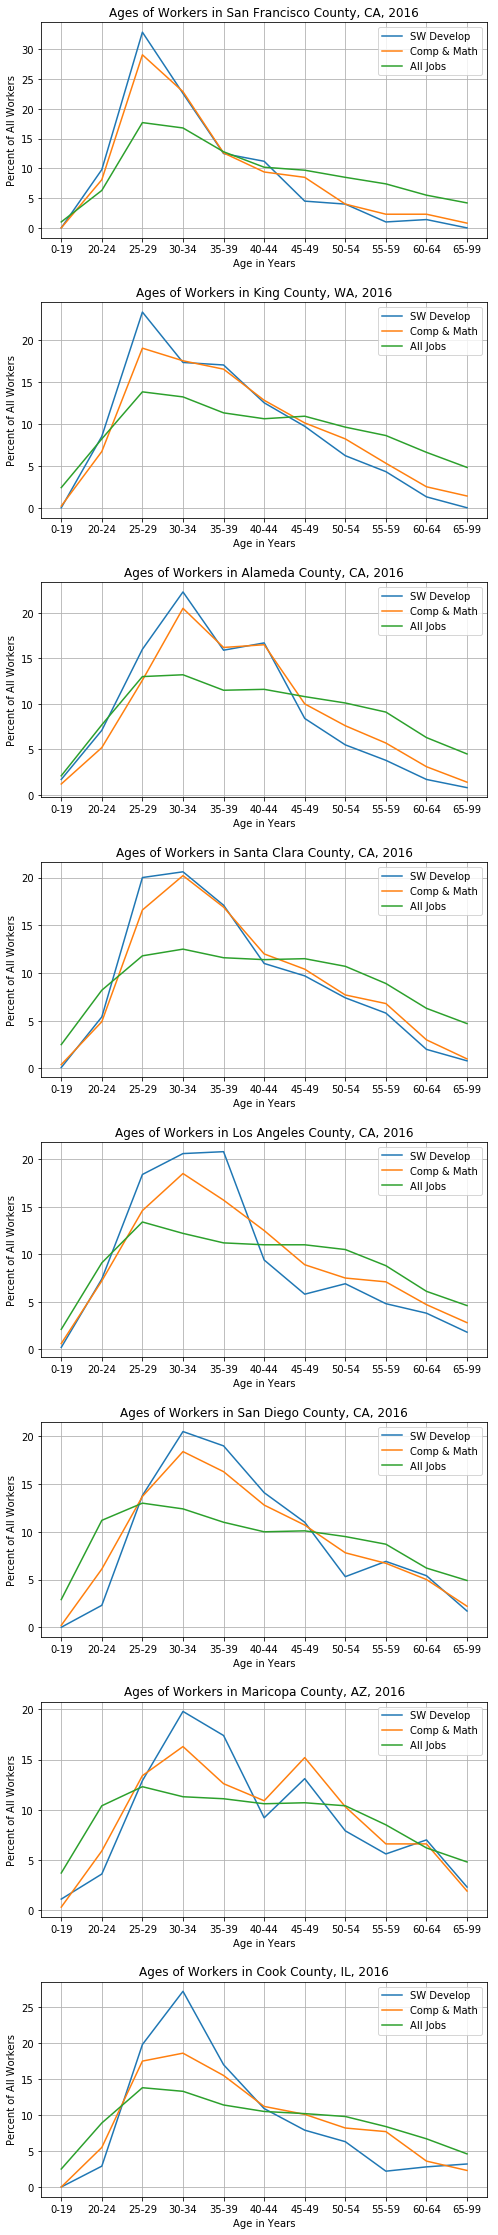

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plotAges(ax, county):
    labels = qq1.columns[2:13]
    SWDevelop = qq1[qq1['County'] == county].iloc[0,2:13]
    CompMath  = qq2[qq2['County'] == county].iloc[0,2:13]
    AllJobs   = qq3[qq3['County'] == county].iloc[0,2:13]
    df = pd.DataFrame({'SW Develop':SWDevelop, 'Comp & Math':CompMath, 'All Jobs':AllJobs})
    df = df[['SW Develop','Comp & Math','All Jobs']]
    ax.plot(labels, df)
    ax.grid(zorder=0)
    scounty = county.replace(",", " County,")
    ax.set_title("Ages of Workers in " + scounty + ", 2016")
    ax.set_xlabel("Age in Years")
    ax.set_ylabel("Percent of All Workers")
    start, end = ax.get_ylim()
    ax.set_yticks(np.arange(0, end, 5))
    ax.legend(df.columns)

fig, axes = plt.subplots(8, 1, figsize=(8, 40))
#fig.subplots_adjust(left=None, bottom=None, right=None, top=None)
fig.subplots_adjust(wspace=None, hspace=0.3)
plotAges(axes[0], 'San Francisco, CA')
plotAges(axes[1], 'King, WA')
plotAges(axes[2], 'Alameda, CA')
plotAges(axes[3], 'Santa Clara, CA')
plotAges(axes[4], 'Los Angeles, CA')
plotAges(axes[5], 'San Diego, CA')
plotAges(axes[6], 'Maricopa, AZ')
plotAges(axes[7], 'Cook, IL')


As can be seen in the graphs, the percentages for All Occupations tends to go from just above zero for the 0-19 age group, up to between about 12 and 14 percent for the 25-29 age group (except for San Francisco with 17.7 percent), and then slopes back down to about 5 percent for the 65 and older age group. For Software Developers, the percentage peaks above 30 percent for San Francisco, CA and above 20 for King, WA, both in the 25-29 age group. The other 6 counties all peak just above 20 percent in the 30-34 age group, except for Cook, IL which peaks above 25 percent for that group and Los Angeles, CA which peaks in the 35-39 age group. The percentage then slopes down relatively sharply to the 65 and old group, reaching close to zero for San Francisco, CA and King, WA, about 1 percent for Alameda, CA and Santa Clara, CA, and 2 to 3 percent for the other 4 counties. For All Computer and Mathematical Occupations, the percentages generally are close to those for Software Developer, just a little less severe in their variability.

From the above graphs, it would appear that ageism does exist in the tech industry and is a little more severe in Silicon Valley and King County, Washington.  However, there is a question as to how much this may be caused by the young age of H-1B workers.  According to Table 5 on page 9 of [Characteristics of H-1B Specialty Occupation Workers, Fiscal Year 2017 Annual Report to Congress](https://www.uscis.gov/sites/default/files/reports-studies/Characteristics-of-Specialty-Occupation-Workers-H-1B-Fiscal-Year-2017.pdf), the largest cohort for all H-1B beneficiaries is the 35-39 group with 40.2 percent.  The Census numbers don't contain H-1B status but this can be estimated by looking at citizenship status.  In fact, this should include workers who are on other types of non-citizen worker visas as well.  The following code is similar to the prior code except that it also divides the data by citizenship status.  As shown [here](https://usa.ipums.org/usa-action/variables/CITIZEN#codes_section), the possible categories are "N/A", "Born abroad of American parents", "Naturalized citizen", and "Not a citizen".  The following code combines the first two categories into the category "Citizen by birth".  


In [19]:
import pandas as pd
# ACS Occupation Codes at https://usa.ipums.org/usa/volii/occ_acs.shtml
# (described at https://www.census.gov/content/dam/Census/library/publications/2016/acs/acs-35.pdf)
#  110 = Computer and information systems managers
# 1010 = Computer programmers
# 1020 = Software developers, applications and systems software 
# print(pd.get_option('display.width'))
pd.set_option('display.width', 120)

def getAgeGroupByCountyCitizen(min_count, occs, ages, cit, isort, ascending, title):
    fipref = "https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt"
    mm = pd.read_csv(fipref, skiprows=0, names=['State','StateCode','CountyCode','County','H1'])
    mm['CountyCode'] *= 10

    usa = pd.read_csv("acs2016.csv")
    usa.loc[usa['CITIZEN'] == 1,'CITIZEN'] = 0
    if len(occs) > 1:
        occ_start = occs[0]
        for i in range(1,len(occs)):
            if occs[i] >= 0:
                occ_end = occs[i]
                usa.loc[usa['OCC'] == occ_end,'OCC'] = occs[0]
            else:
                occ_end = -occs[i]
                usa.loc[(usa['OCC'] >= occ_start) & (usa['OCC'] <= occ_end),'OCC'] = occs[0]
            occ_start = occ_end + 1
    agevars = ['0-' + str(ages[0]-1)]
    usa.loc[usa['AGE'] < ages[0],'AGE'] = 1000
    for i in range (1,len(ages)):
        agevars.append(str(ages[i-1]) + '-' + str(ages[i]-1))
        usa.loc[usa['AGE'] < ages[i],'AGE'] = (i+1000)
    agevars.append(str(ages[len(ages)-1]) + '-99')
    usa.loc[usa['AGE'] < 1000,'AGE'] = (len(ages)+1000)
    #print("usa[{0}] = {1}".format(usa.shape[0], sum(usa['PERWT'])))
    print("usa[%d] = %d\n" % (usa.shape[0], sum(usa['PERWT'])))

    gg = usa.groupby(['STATEFIP','COUNTY','AGE','EMPSTAT','OCC','CITIZEN'])['PERWT'].sum()
    uu = gg.unstack('AGE')
    uu.columns = agevars
    uu = uu.fillna(0)
    uu['count'] = 0
    for i in range(0, len(agevars)):
        uu['count'] = uu['count'] + uu[agevars[i]]
    #for i in range(0, len(agevars)):
    #    uu[agevars[i]] = (100 * uu[agevars[i]] / uu['count']).round(1)
    uu = uu.reset_index(level=['STATEFIP','COUNTY','EMPSTAT','OCC','CITIZEN'])
    pp = uu[(uu['OCC'] == occs[0]) & (uu['EMPSTAT'] == 1)  & (uu['CITIZEN'] == cit) & (uu['count'] > min_count)]
    if isort < 0:
        isort = len(agevars)-1
        pp = pp.sort_values(by=[agevars[isort],agevars[isort-1],agevars[isort-2]], ascending=ascending)
    else:
        pp = pp.sort_values(by=[agevars[isort]], ascending=ascending)
    
    pp = pp[pp['COUNTY'] > 0]
    pp = pp.merge(mm, left_on=['STATEFIP','COUNTY'],right_on=['StateCode','CountyCode'],how='left')
    qqCounty = pp['County'].str.replace(' County','') + ", " + pp['State']
    qq=pd.DataFrame(qqCounty, columns=['County'])
    qq['count']=pp['count'].astype('int')
    for i in range(0, len(agevars)):
        #qq[agevars[i]]=pp[agevars[i]]
        qq[agevars[i]]=pp[agevars[i]].astype(int)
    print(title)
    print(qq)
    return(qq)

# qq1 = getAgeGroupByCounty(5000, [1020], [20,25,30,35,40,45,50,55,60,65], -1, True,
#                           "Software Developers - Percent of Workers in Selected Age Groups\n")
qq1usa = getAgeGroupByCountyCitizen(4000, [1020], [20,25,30,35,40,45,50,55,60,65], 0, -1, True,
                          "Software Developers - Number of US-born Citizens in Selected Age Groups\n")
qq1nat = getAgeGroupByCountyCitizen(1000, [1020], [20,25,30,35,40,45,50,55,60,65], 2, -1, True,
                          "Software Developers - Number of Naturalized Citizens in Selected Age Groups\n")
qq1nac = getAgeGroupByCountyCitizen(2000, [1020], [20,25,30,35,40,45,50,55,60,65], 3, -1, True,
                          "Software Developers - Number of Non-citizens in Selected Age Groups\n")


usa[3156487] = 323127515

Software Developers - Number of US-born Citizens in Selected Age Groups

               County  count  0-19  20-24  25-29  30-34  35-39  40-44  45-49  50-54  55-59  60-64  65-99
0         Suffolk, MA   4466   125    942   1278   1229    190    272    263     74     93      0      0
1        New York, NY   5785     0    756   1683    777   1420    319    596     97    137      0      0
2            Dane, WI   5667     0   2119   1050    432    428    996    356     21    265      0      0
3      Williamson, TX   5213     0      0    681   1002    389    630    767   1544     92    108      0
4   San Francisco, CA  12177     0   1813   3838   2887   1453   1155    285    379    203    164      0
5           Kings, NY   5021     0    195   1610   1634    464    398    116    269     77    258      0
6          Orange, CA   7702     0    651   1776   1632    893    440   1079    535    305    391      0
7            Wake, NC  10650     0    498    752   1477   143

usa[3156487] = 323127515

Software Developers - Number of Non-citizens in Selected Age Groups

               County  count  0-19  20-24  25-29  30-34  35-39  40-44  45-49  50-54  55-59  60-64  65-99
0    Contra Costa, CA   2661     0      0    266    383    418   1118    373    103      0      0      0
1   San Francisco, CA   5248     0    180   2576   1076    652    486    175    103      0      0      0
2       San Mateo, CA   6369     0    110   2445   2203    918    441    252      0      0      0      0
3            Cook, IL   7218     0    239   1902   3194   1080    399    341     63      0      0      0
4          DuPage, IL   2206     0      0    388    499    678    424      0    217      0      0      0
5        Hennepin, MN   3223     0      0   1365    980    372    506      0      0      0      0      0
6          Bergen, NJ   2026     0      0    557    614    399    285    171      0      0      0      0
7          Hudson, NJ   4998     0    199   1157   2167   1310   

As can be seen, counties are sorted by the highest three age groups in reverse order.

The following code plots the data for workers with OCC code 1020 (Software developers, applications and systems software) for the 8 counties with the most software developers as before.  It also plots the data for San Mateo County so as to include all four of the counties (Santa Clara, Alameda, San Francisco, and San Mateo) in the Silicon Valley region.


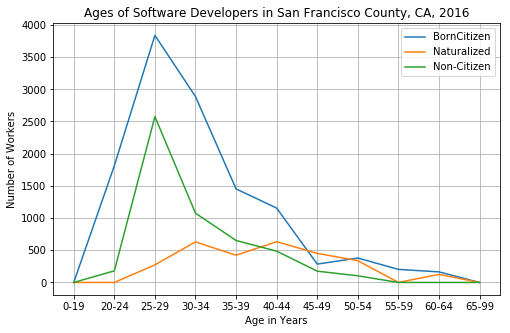

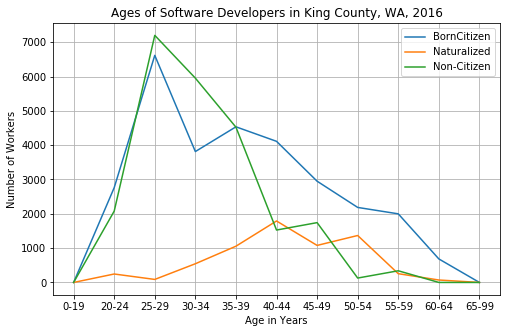

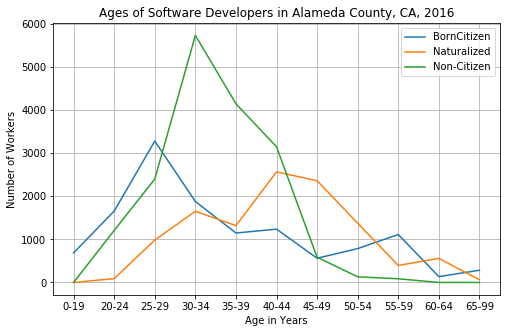

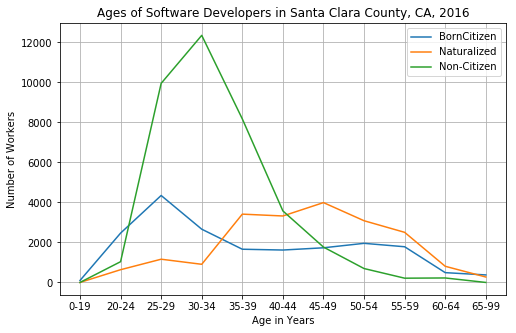

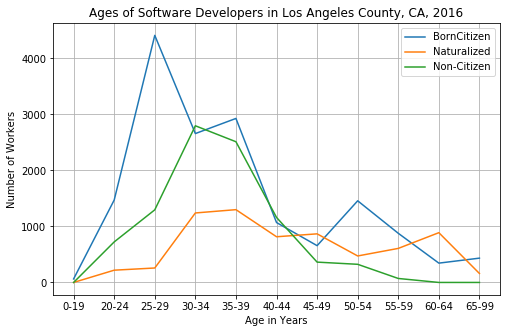

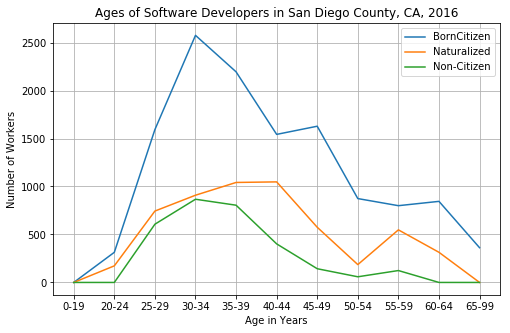

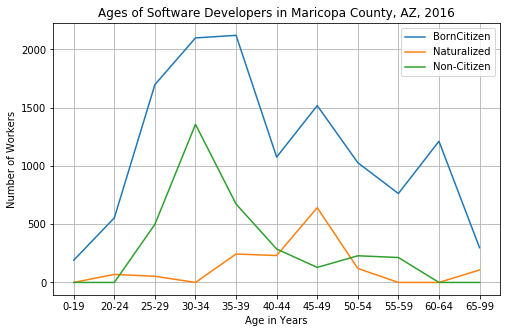

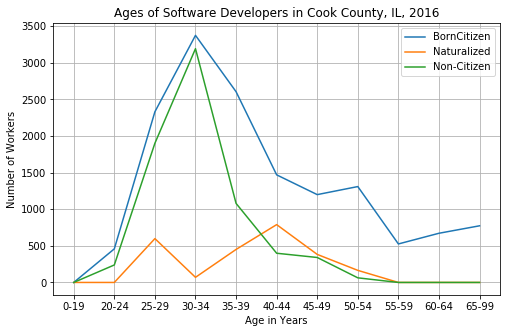

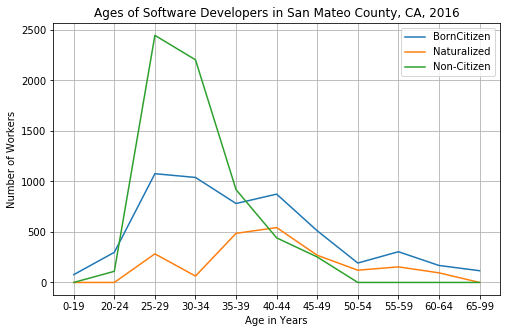

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plotAgesCitizen(fig, ax, county):
    labels = qq1usa.columns[2:13]
    BornCitizen = qq1usa[qq1usa['County'] == county].iloc[0,2:13]
    Naturalized = qq1nat[qq1nat['County'] == county].iloc[0,2:13]
    NonCitizen = qq1nac[qq1nac['County'] == county].iloc[0,2:13]
    df = pd.DataFrame({'BornCitizen':BornCitizen, 'Naturalized':Naturalized, 'Non-Citizen':NonCitizen})
    df = df[['BornCitizen','Naturalized','Non-Citizen']]
    ax.plot(labels, df)
    ax.grid(zorder=0)
    scounty = county.replace(",", " County,")
    fcounty = county.replace(" ", "")
    fcounty = fcounty.replace(",", "")
    ax.set_title("Ages of Software Developers in " + scounty + ", 2016")
    ax.set_xlabel("Age in Years")
    ax.set_ylabel("Number of Workers")
    start, end = ax.get_ylim()
    #ax.set_yticks(np.arange(0, end, 5))
    ax.legend(df.columns)
    fig.savefig(fcounty+"16.png")

#fig, axes = plt.subplots(8, 1, figsize=(8, 40))
wd = 8
ht = 5
fig0, axes0 = plt.subplots(1, 1, figsize=(wd, ht))
fig1, axes1 = plt.subplots(1, 1, figsize=(wd, ht))
fig2, axes2 = plt.subplots(1, 1, figsize=(wd, ht))
fig3, axes3 = plt.subplots(1, 1, figsize=(wd, ht))
fig4, axes4 = plt.subplots(1, 1, figsize=(wd, ht))
fig5, axes5 = plt.subplots(1, 1, figsize=(wd, ht))
fig6, axes6 = plt.subplots(1, 1, figsize=(wd, ht))
fig7, axes7 = plt.subplots(1, 1, figsize=(wd, ht))
fig8, axes8 = plt.subplots(1, 1, figsize=(wd, ht))
#fig.subplots_adjust(left=None, bottom=None, right=None, top=None)
#fig.subplots_adjust(wspace=None, hspace=0.3)
plotAgesCitizen(fig0, axes0, 'San Francisco, CA')
plotAgesCitizen(fig1, axes1, 'King, WA')
plotAgesCitizen(fig2, axes2, 'Alameda, CA')
plotAgesCitizen(fig3, axes3, 'Santa Clara, CA')
plotAgesCitizen(fig4, axes4, 'Los Angeles, CA')
plotAgesCitizen(fig5, axes5, 'San Diego, CA')
plotAgesCitizen(fig6, axes6, 'Maricopa, AZ')
plotAgesCitizen(fig7, axes7, 'Cook, IL')
plotAgesCitizen(fig8, axes8, 'San Mateo, CA')


As can be seen in the above graphs, software developers tend to be young for both US-born and non-citzen workers.  For US-born workers, the largest age cohort was 25-29 for all of the counties except for San Diego and Cook (30-34) and Maricopa (35-39).  For non-citizens, the largest age cohort was 30-34 for all of the counties except for San Francisco, San Mateo, and King.  Interestingly, the largest age cohort for naturalized citizens was 40-44 for all of the counties except for Santa Clara and Maricopa (45-49) and Los Angeles (35-39).  It's unclear why the largest age cohort for naturalized citizens is so much higher.  It may be that many of them worked as non-citzens or immigrated later in their careers.  In any case, one other fact suggested by the graphs is that the largest percentage of non-citizen software developers work in Santa Clara, Alameda, and San Mateo counties.  All three are in the Silicon Valley region.

From the above graphs, it would appear that ageism does exist in the tech industry and is a little more severe in Silicon Valley and King County, Washington.  However, there are some who disagree, at least as to its severity.  For example, an article titled [No place for the old? Is software development a young person's game?](https://www.techrepublic.com/article/no-place-for-the-old-is-software-development-a-young-persons-game/) concludes:

> Natalia Radcliffe-Brine, marketing manager at Stack Overflow, is inclined to view the figures as evidence that more young people are entering the profession than ever before.

> "I don't think it's that the older developers aren't there anymore, I think there's been momentum around technology and you've got so many more young people going into computer science."

> In the UK there are signs of burgeoning growth, both in jobs in the wider tech industry and in the numbers studying computer science. Following the 2008 global crash, the rate of job creation at UK technology companies was found to be far outstripping that within the wider private sector, and Cambridge University recently saw the number of people applying to study computer science pass the high watermark of late 90s dotcom boom.

> "The proportion is changing, so instead of having lots of older people in the industry, you have so many more young people coming into it now," she said.

> "That's why the age looks a lot younger. I definitely don't think it's that the older developers aren't there."

It certainly is true that one needs to consider the degree to which the tech industry is growing.  In theory, it would be possible for all of the non-retired older workers to still be working but to have their percentages become less due to an increasing number of young workers.  However, that would not explain the differences between Silicon Valley and King County and other counties and the severity of the drops shown in the graphs above.  It would seem that it would be useful if someone could actually survey older workers, especially those who have been laid off, and get their input on whether they are still working in the tech industry and, if not, why not.  It would also help if tech companies would release their workforce demographics.  In any case, there would seem to be enough evidence of some amount of ageism to warn all people going into the field that they may have to shift into another field as early as 40 or 50 and to seriously prepare for that possibilty.

Note: The Jupyter Notebook from which this post is generated can be found at [http://econdataus.com/ageism_tech.ipynb](http://econdataus.com/ageism_tech.ipynb).
